# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Random Forest Classifier. 
- Try Ordinal Encoding.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top & bottom of this notebook:

In [1]:
!pip install category_encoders

In [2]:
!pip install graphviz

In [3]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [0]:
LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(WEB + 'train_features.csv'), 
                 pd.read_csv(WEB + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(WEB + 'test_features.csv')
sample_submission = pd.read_csv(WEB + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)    
    # Extract components from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    # Drop quantity_group (duplicate columns)
    # Drop date_recorded (datetime doesn't get work well in analysis)
    X = X.drop(columns=['recorded_by', 'id','date_recorded','quantity_group'])
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

## DecisionTreeClassifier & OneHotEncoder

In [42]:
%%time
target = 'status_group'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
categorical_features = train_features.describe(exclude='number').T.query('unique <= 50').index.tolist()
features = numeric_features + categorical_features

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    DecisionTreeClassifier(max_depth=20, random_state=42)
)

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.7712121212121212
CPU times: user 6.41 s, sys: 151 ms, total: 6.56 s
Wall time: 6.57 s


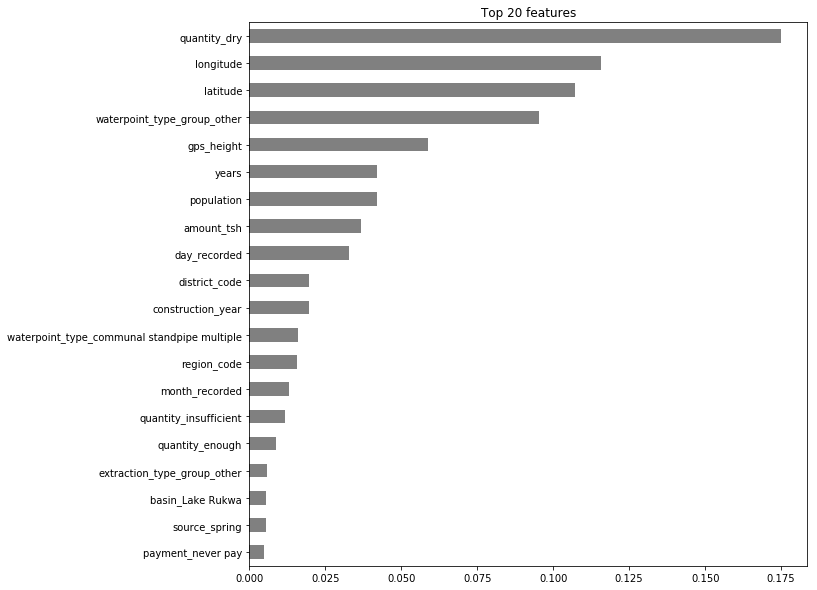

In [23]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

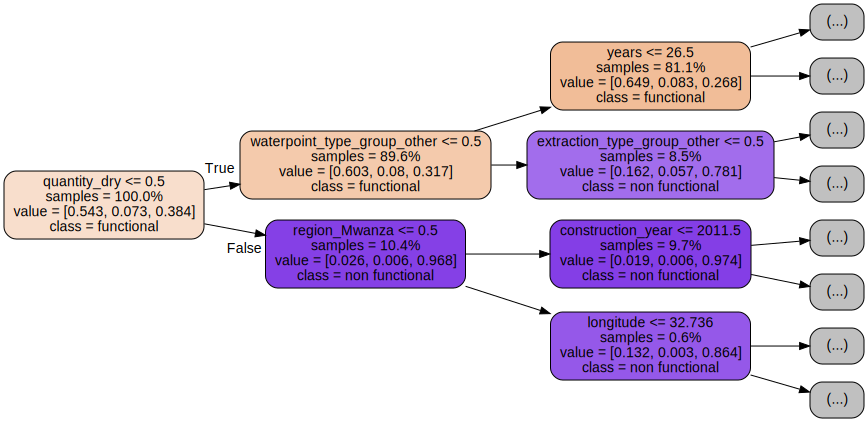

In [43]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, 
                           out_file=None, 
                           max_depth=2, 
                           feature_names=feature_names, 
                           class_names=tree.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rotate=True, 
                           rounded=True)

graphviz.Source(dot_data)

## RandomForestClassifier & OneHotEncoder

In [81]:
%%time
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

target = 'status_group'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
categorical_features = train_features.describe(exclude='number').T.query('unique <= 50').index.tolist()
features = categorical_features + numeric_features

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8075757575757576
CPU times: user 22.6 s, sys: 153 ms, total: 22.8 s
Wall time: 14 s


In [46]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['onehotencoder']
shape = encoder.transform(X_train).shape
print('X_train shape after encoding', shape)

X_train shape before encoding (47520, 33)
X_train shape after encoding (47520, 183)


## RandomForestClassifier & OrdinalEncoder

In [122]:
train.describe(exclude='number').sort_values(by='unique', axis=1)

,public_meeting,permit,status_group,source_class,quantity,management_group,quality_group,waterpoint_type_group,source_type,waterpoint_type,payment_type,extraction_type_class,payment,water_quality,basin,source,scheme_management,management,extraction_type_group,extraction_type,region,lga,funder,installer,ward,scheme_name,subvillage,wpt_name
count,44876,45077,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,44392,47520,47520,47520,47520,47520,44616,44603,47520,24988,47234,47520
unique,2,2,3,3,5,5,6,6,7,7,7,7,7,8,9,10,12,12,13,18,21,124,1716,1929,2082,2563,17231,30661
top,True,True,functional,groundwater,enough,user-group,good,communal standpipe,spring,communal standpipe,never pay,gravity,never pay,soft,Lake Victoria,spring,VWC,vwc,gravity,gravity,Iringa,Njombe,Government Of Tanzania,DWE,Igosi,K,Shuleni,none
freq,40838,31071,25807,36638,26567,42027,40598,27642,13620,22778,20287,21448,20287,40598,8137,13620,29470,32449,21448,21448,4250,2003,7321,13978,257,548,420,2879


In [133]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

target = 'status_group'
train_features = train.drop(columns=[target])
categorical_features = train_features.describe(exclude='number').T.index.tolist()
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Fit on train, score on val
pipeline.fit(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Validation Accuracy', val_score*100)

Validation Accuracy 80.93434343434343
CPU times: user 18.2 s, sys: 79.8 ms, total: 18.3 s
Wall time: 10.1 s


In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# features = importances.sort_values()[-37:].index.tolist()
# features

In [135]:
new_f_score = []
new_f = importances.sort_values().index.tolist()
for x in range(30, len(new_f)+1):
  new_f = importances.sort_values()[-x:].index.tolist()
  
  pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
  )
  
  X_train_subset = train[new_f]
  X_val_subset = val[new_f]

  pipeline.fit(X_train_subset, y_train)
  print(x, pipeline.score(X_val_subset, y_val)*100)
  if pipeline.score(X_val_subset, y_val) > val_score:
    val_score = pipeline.score(X_val_subset, y_val)
    new_f_score = [x, val_score]
new_f_score

25 80.8080808080808
26 80.78282828282828
27 80.47138047138047
28 80.9006734006734
29 81.01851851851852
30 80.79124579124579
31 80.85016835016835
32 81.01851851851852
33 81.0942760942761
34 80.95959595959596
35 80.77441077441078
36 81.01010101010101
37 81.12794612794613
38 80.91750841750842
39 80.84175084175084


[37, 0.8112794612794613]

In [138]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

target = 'status_group'
features = importances.sort_values()[-37:].index.tolist()

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Fit on train, score on val
pipeline.fit(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print('Validation Accuracy', val_score*100)

Validation Accuracy 81.12794612794613
CPU times: user 18.2 s, sys: 69.9 ms, total: 18.3 s
Wall time: 10 s


In [0]:
# model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# rfe = RFE(model, 33)
# fit = rfe.fit(X_train, y_train)

In [51]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['ordinalencoder']
shape = encoder.transform(X_train).shape
print('X_train shape after encoding', shape)

X_train shape before encoding (47520, 40)
X_train shape after encoding (47520, 40)


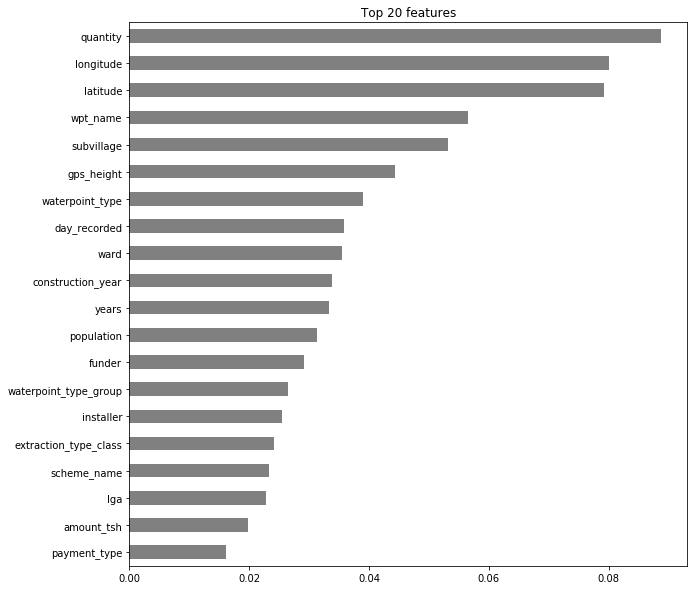

In [139]:
# TODO

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# Write submission csv file

In [0]:
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-05.csv', index=False)

### Post-read links

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- [Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)
- [Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)